# BM25: A Better TF-IDF for Text Retrieval

In this notebook, we'll explore BM25 (Best Matching 25), a ranking function that extends the traditional TF-IDF model with improvements for document retrieval. We'll compare BM25 with TF-IDF.

## Industrial Use Case: Enterprise Knowledge Base Search

Many large organizations maintain extensive knowledge bases containing documentation, FAQs, product manuals, and internal policies. Employees need to find relevant information quickly when troubleshooting issues or answering customer queries.

**Use Case Scenario:** We are implementing a search function for a technical support knowledge base where employees can find relevant articles about known issues and solutions. When an employee searches for a specific problem, the system needs to retrieve the most relevant documents, even if they don't use exactly the same terminology.

We'll model this using the IMDB dataset, as we did in the previous notebook.

One common mistake when it comes to RAG (we'll talk about this in Session 9) is to use complex retriever models. In this case, we'll use a simple vector-based retriever (cosine similarity) to retrieve paragraphs from the same section.

## Our Objectives:

1. Implement a BM25Vectorizer that inherits from the same base class as TfidfVectorizer
2. Visualize differences in the sparse representations
3. Look into creating a retrieval pipeline with the BM25Vectorizer
4. Compare the performance of BM25 with TF-IDF on IMDB dataset

Let's begin!

## Setup and Imports

First, we'll import the necessary libraries and set a random seed for reproducibility.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, _document_frequency
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Set random seed for reproducibility
np.random.seed(42)
import random
random.seed(42)

## 1. Load and Explore the Data

We'll use the `imbd` dataset, which contains IMDB reviews with a label indicating if the review is positive or negative.

In [2]:
# Load the imdb
dataset = load_dataset('imdb')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
# Convert to pandas DataFrame for easier manipulation
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
# Clean the memory
del dataset

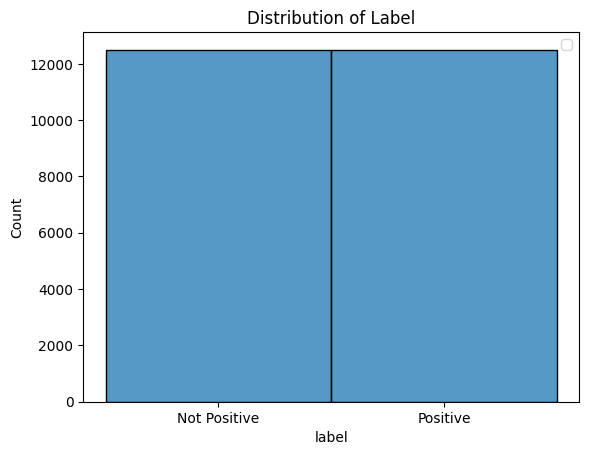

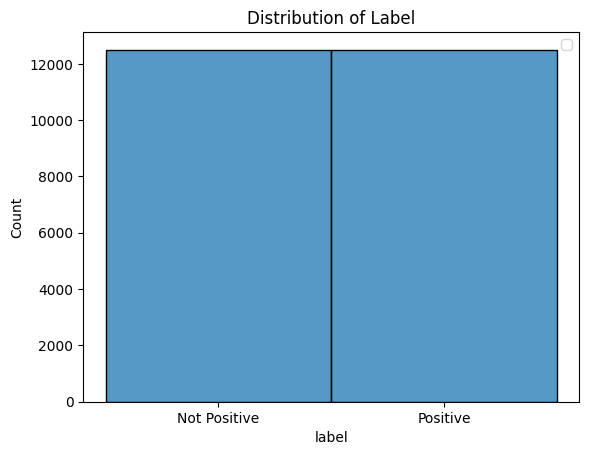

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [4]:
#Distribution of label
sns.histplot(train_df['label'], bins=2)
plt.title('Distribution of Label')
plt.xticks([0.25, 0.75], ['Not Positive', 'Positive'])
plt.legend()
plt.show()

#Distribution of label
sns.histplot(test_df['label'], bins=2)
plt.title('Distribution of Label')
plt.xticks([0.25, 0.75], ['Not Positive', 'Positive'])
plt.legend()
plt.show()

# Display a sample
test_df.head()

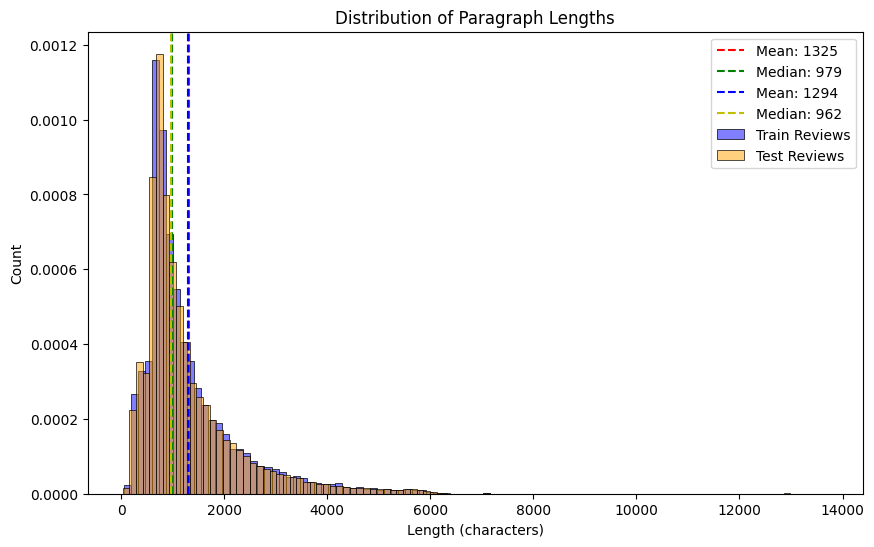

In [5]:
# Look at the distribution of paragraph lengths
train_df['review_length'] = train_df['text'].apply(len)
test_df['review_length'] = test_df['text'].apply(len)

plt.figure(figsize=(10, 6))
#normalized histograms
sns.histplot(train_df['review_length'], bins=100, label='Train Reviews', stat='density', color='blue', alpha=0.5)
sns.histplot(test_df['review_length'], bins=100, label='Test Reviews', stat='density', color='orange', alpha=0.5)


plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.axvline(x=train_df['review_length'].mean(), color='r', linestyle='--', label=f'Mean: {train_df["review_length"].mean():.0f}')
plt.axvline(x=train_df['review_length'].median(), color='g', linestyle='--', label=f'Median: {train_df["review_length"].median():.0f}')
plt.axvline(x=test_df['review_length'].mean(), color='b', linestyle='--', label=f'Mean: {test_df["review_length"].mean():.0f}')
plt.axvline(x=test_df['review_length'].median(), color='y', linestyle='--', label=f'Median: {test_df["review_length"].median():.0f}')
plt.legend()
plt.show()

The distributions are quite similar with equal labels in both train and test. We don't need to do any balancing here.

## 2. Implementation of BM25Vectorizer

BM25 is an improvement over TF-IDF that addresses some of its limitations:

1. It handles term frequency saturation better (multiple occurrences of a term give diminishing returns)
2. It accounts for document length normalization in a more principled way

The BM25 formula is:

$$\text{BM25}(D,Q) = \sum_{i=1}^{n} \text{IDF}(q_i) \cdot \frac{f(q_i, D) \cdot (k_1 + 1)}{f(q_i, D) + k_1 \cdot (1 - b + b \cdot \frac{|D|}{avgdl})}$$

Where:
- $f(q_i, D)$ is the term frequency of term $q_i$ in document $D$
- $|D|$ is the length of document $D$
- $avgdl$ is the average document length across the corpus
- $k_1$ and $b$ are free parameters (typically, $k_1 \in [1.2, 2.0]$ and $b = 0.75$)
- $\text{IDF}(q_i)$ is the inverse document frequency of term $q_i$

Let's implement a `BM25Vectorizer` that can be used as a drop-in replacement for scikit-learn's `TfidfVectorizer`.

In [6]:
from scipy import sparse

class BM25Vectorizer(CountVectorizer):
    """Convert a collection of text documents to a matrix of BM25 scores.
    
    This implementation follows the Okapi BM25 formula and extends CountVectorizer
    to allow for seamless integration with scikit-learn pipelines.
    
    Parameters
    ----------
    k1 : float, default=1.5
        Controls term frequency saturation
    b : float, default=0.75
        Controls how much document length normalization affects the score
    norm : {'l1', 'l2'}, default=None
        Optional normalization
    use_idf : bool, default=True
        Whether to use inverse document frequency weighting
    smooth_idf : bool, default=True
        Smooth IDF weights by adding 1 to document frequencies
    sublinear_tf : bool, default=False
        Apply sublinear scaling to term frequencies (1 + log(tf))
    """
    
    def __init__(self, input='content', encoding='utf-8', decode_error='strict',
                 strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None,
                 stop_words=None, token_pattern=r"(?u)\b\w\w+\b", ngram_range=(1, 1),
                 analyzer='word', max_df=1.0, min_df=1, max_features=None,
                 vocabulary=None, binary=False, dtype=np.int64,
                 k1=1.5, b=0.75, norm=None, use_idf=True, 
                 smooth_idf=True, sublinear_tf=False):
        
        # Initialize CountVectorizer with all its parameters
        super().__init__(
            input=input, encoding=encoding, decode_error=decode_error,
            strip_accents=strip_accents, lowercase=lowercase,
            preprocessor=preprocessor, tokenizer=tokenizer,
            stop_words=stop_words, token_pattern=token_pattern,
            ngram_range=ngram_range, analyzer=analyzer,
            max_df=max_df, min_df=min_df, max_features=max_features,
            vocabulary=vocabulary, binary=binary, dtype=dtype
        )
        
        # BM25-specific parameters
        self.k1 = k1
        self.b = b
        self.norm = norm
        self.use_idf = use_idf
        self.smooth_idf = smooth_idf
        self.sublinear_tf = sublinear_tf
        
    def fit(self, X, y=None):
        """Learn vocabulary and document frequencies from training set."""
        X = super().fit_transform(X)
        
        if self.use_idf:
            n_samples, n_features = X.shape
            df = _document_frequency(X)
            
            # Calculate IDF scores
            idf = np.log((n_samples - df + 0.5) / (df + 0.5) + 1.0)
            self._idf_diag = sparse.diags(idf, offsets=0,
                                         shape=(n_features, n_features),
                                         format="csr")
        
        # Calculate average document length for BM25
        self._avgdl = X.sum(axis=1).mean()
        
        return self
        
    def transform(self, X):
        """Transform documents to BM25 vectors."""
        # Transform documents to term frequency vectors
        X = super().transform(X)
        
        if self.sublinear_tf:
            # Apply sublinear term frequency scaling: tf -> 1 + log(tf)
            np.log1p(X.data, out=X.data)
        
        # Apply BM25 term frequency transformation
        doc_lengths = X.sum(axis=1).A1
        
        # Calculate document length normalization factors
        len_norm = (1 - self.b) + self.b * (doc_lengths / self._avgdl)
        
        # Implement BM25 term frequency transformation in a vectorized way
        # For each non-zero element in the sparse matrix:
        # tf_scaled = tf * (k1 + 1) / (tf + k1 * len_norm)
        denominator = np.repeat(len_norm, np.diff(X.indptr))
        
        # Calculate BM25 term frequency score
        X.data = X.data * (self.k1 + 1) / (X.data + self.k1 * denominator)
        
        if self.use_idf:
            # Apply IDF weighting
            check_is_fitted(self, '_idf_diag')
            X = X * self._idf_diag
            
        if self.norm:
            # Apply normalization
            X = normalize(X, norm=self.norm, copy=False)
            
        return X
    
    def fit_transform(self, X, y=None):
        """Learn vocabulary and document frequencies, and transform documents to BM25 vectors."""
        # Call fit and then transform
        return self.fit(X).transform(X)

## 3. Implement and Compare the Retrieval Methods

Now, we'll implement and compare two methods for paragraph retrieval:
1. TF-IDF with cosine similarity
2. BM25 with cosine similarity

In [7]:
reviews = train_df['text'].tolist()

# Initialize vectorizers
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.85, ngram_range=(1, 2), 
                                   sublinear_tf=True, norm='l2', stop_words="english")
bm25_vectorizer = BM25Vectorizer(min_df=3, max_df=0.85, ngram_range=(1, 2), 
                                 k1=1.5, b=0.75, norm='l2', stop_words="english")

# Fit the vectorizers
print("Fitting TF-IDF vectorizer...")
start_time = time.time()
tfidf_vectorizer.fit(reviews)
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\nFitting BM25 vectorizer...")
start_time = time.time()
bm25_vectorizer.fit(reviews)
print(f"BM25 vocabulary size: {len(bm25_vectorizer.vocabulary_)}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

Fitting TF-IDF vectorizer...
TF-IDF vocabulary size: 159213
Time taken: 4.74 seconds

Fitting BM25 vectorizer...
BM25 vocabulary size: 159213
Time taken: 4.78 seconds


We see that we have the same vocabulary size for both vectorizers. the main changes will be in the term weighting. And in term of fitting time both are quite similar too. 

### Visualize Differences in Vector Representations

Let's look at the differences between TF-IDF and BM25 representations for a few example paragraphs. This will help us understand how BM25 modifies the term weighting.

In [8]:
start_time = time.time()
reviews_tfidf = tfidf_vectorizer.transform(reviews)
print(f"TF-IDF Vectorization: {time.time() - start_time:.2f} seconds")

start_time = time.time()
reviews_bm25 = bm25_vectorizer.transform(reviews)
print(f"BM25 Vectorization: {time.time() - start_time:.2f} seconds")

TF-IDF Vectorization: 3.59 seconds
BM25 Vectorization: 3.62 seconds


Again we see that the transformation time is quite similar.

In [9]:
def get_top_terms(vectorizer, matrix, doc_idx, top_n=10):
    """Get the top weighted terms for a document from a vectorizer matrix."""
    feature_names = np.array(vectorizer.get_feature_names_out())
    doc_vector = matrix[doc_idx].toarray().flatten()
    
    # Get indices of top weighted terms
    top_indices = doc_vector.argsort()[-top_n:][::-1]
    
    # Get terms and weights
    top_terms = feature_names[top_indices]
    weights = doc_vector[top_indices]
    
    return list(zip(top_terms, weights))

# Get a few example paragraphs
example_indices = np.random.randint(0, len(train_df), 5)
example_paragraphs = [reviews[idx] for idx in example_indices]

# Compare TF-IDF and BM25 representations
for i, idx in enumerate(example_indices):
    print(f"\nExample {i+1}: {example_paragraphs[i]}...")
    
    print("\nTop TF-IDF terms:")
    tfidf_terms = get_top_terms(tfidf_vectorizer, reviews_tfidf, idx)
    for term, weight in tfidf_terms:
        print(f"  {term}: {weight:.4f}")
    
    print("\nTop BM25 terms:")
    bm25_terms = get_top_terms(bm25_vectorizer, reviews_bm25, idx)
    for term, weight in bm25_terms:
        print(f"  {term}: {weight:.4f}")
    
    print("\n" + "-"*80)


Example 1: I first saw "Breaking Glass" in 1980, and thought that it would be one of the "Movie Classics". This film is a great look into the music industry with a great cast of performers. This is one film that should be in the collection of everyone and any one that wants to get into the music industry. I can't wait for it to be available on DVD....

Top TF-IDF terms:
  music industry: 0.3558
  industry great: 0.2431
  classics film: 0.2431
  cast performers: 0.2431
  look music: 0.2431
  breaking glass: 0.2330
  movie classics: 0.2330
  industry: 0.2275
  performers film: 0.2258
  film collection: 0.2101

Top BM25 terms:
  music industry: 0.2824
  look music: 0.2696
  industry great: 0.2696
  classics film: 0.2696
  cast performers: 0.2696
  breaking glass: 0.2559
  movie classics: 0.2559
  performers film: 0.2465
  film collection: 0.2265
  great look: 0.2191

--------------------------------------------------------------------------------

Example 2: Went to see this finnish film

Let's visualize the weight differences between TF-IDF and BM25 for one document.

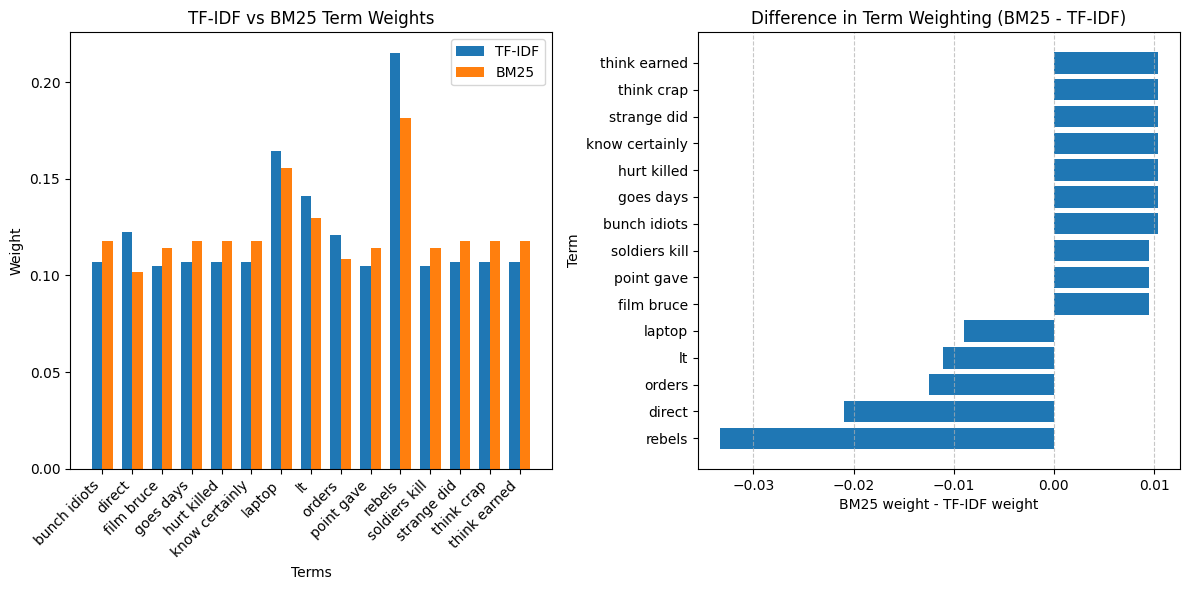

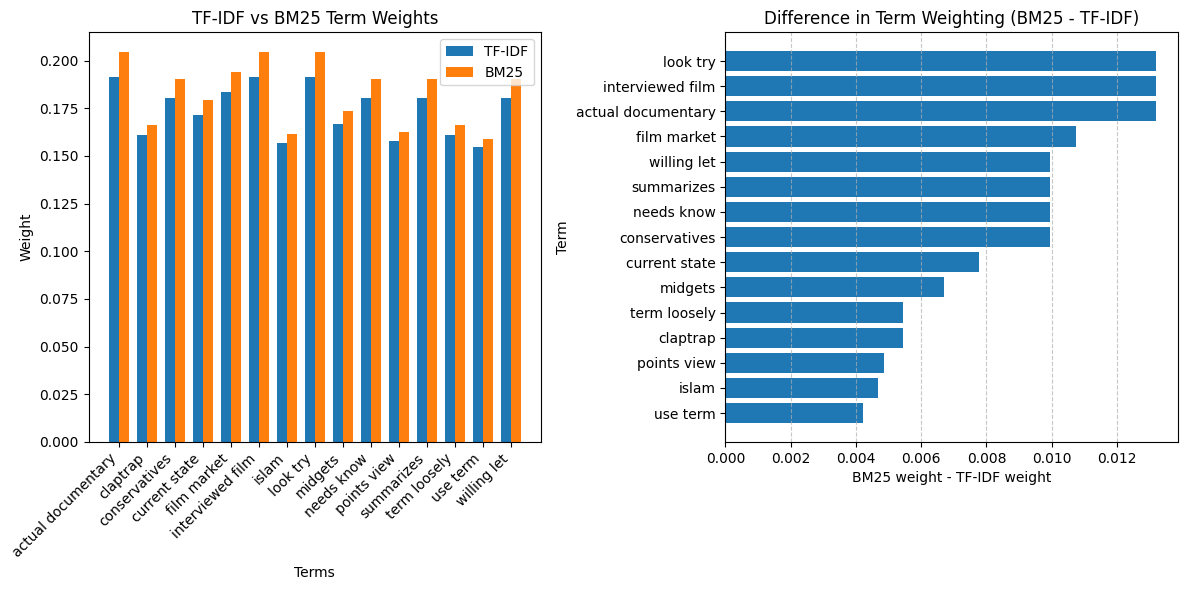

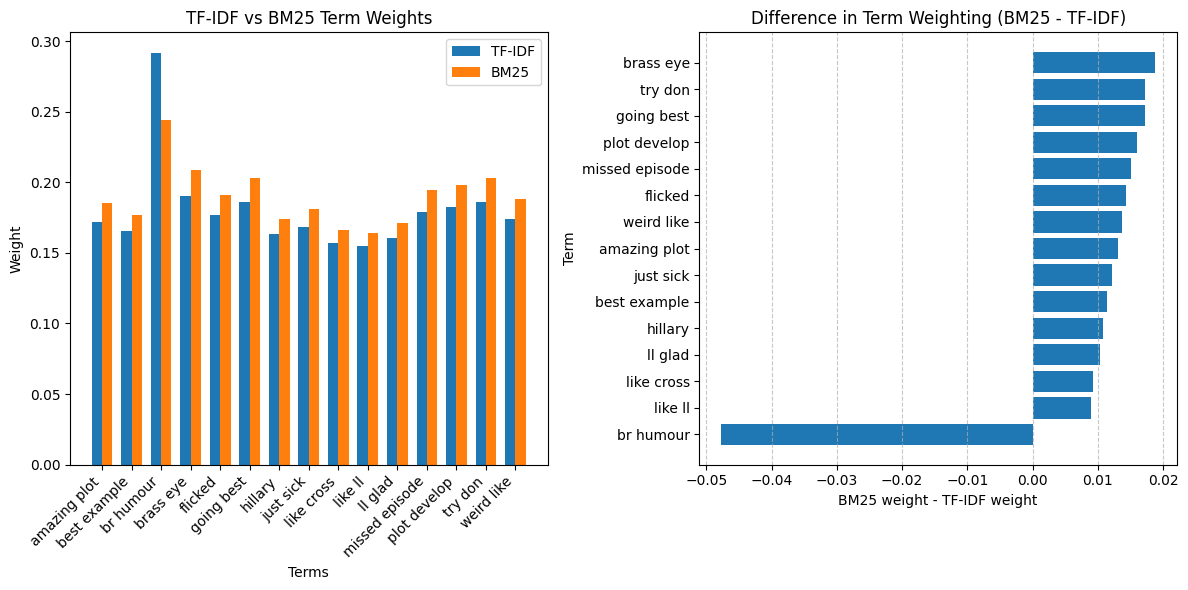

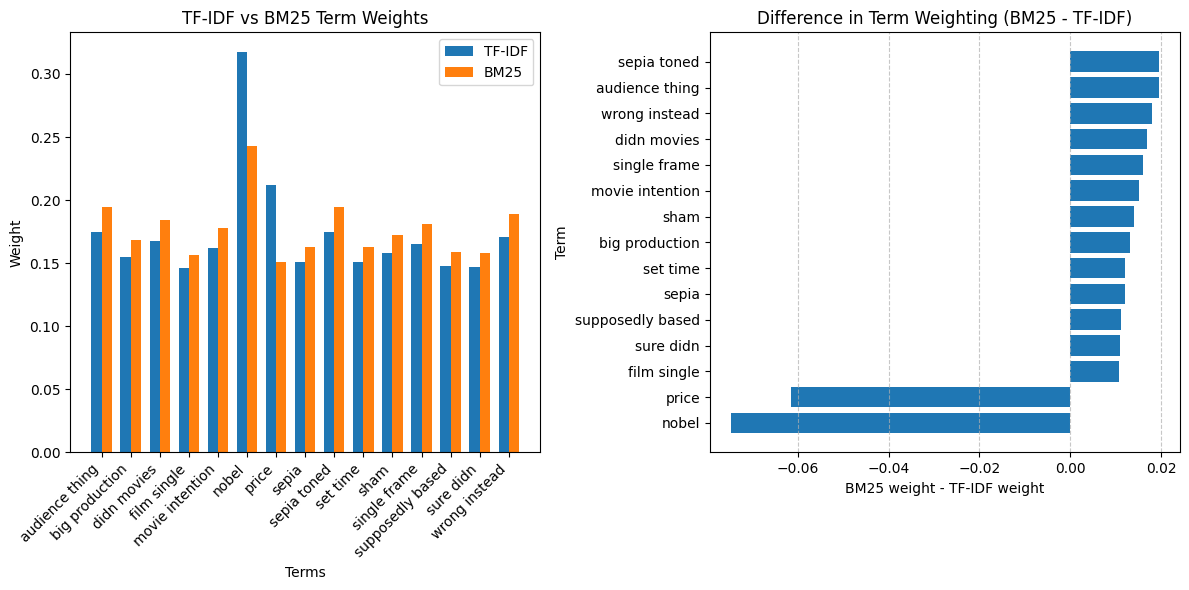

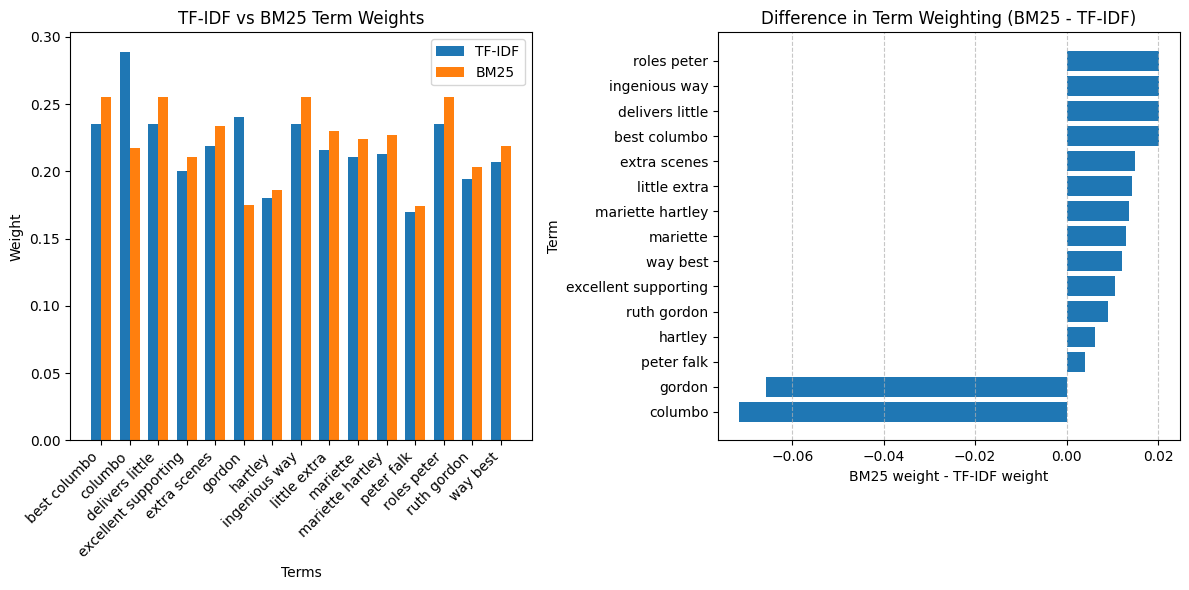

In [10]:
for doc_idx in np.random.randint(0, len(train_df), 5):
    # Get TF-IDF and BM25 term weights for the selected document
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

    # Get the non-zero terms from both vectors
    tfidf_vector = reviews_tfidf[doc_idx].toarray().flatten()
    bm25_vector = reviews_bm25[doc_idx].toarray().flatten()

    non_zero_idx = np.logical_or(tfidf_vector > 0, bm25_vector > 0)
    terms = feature_names[non_zero_idx]
    tfidf_weights = tfidf_vector[non_zero_idx]
    bm25_weights = bm25_vector[non_zero_idx]

    # Find the top 15 terms by the sum of both weights
    top_idx = np.argsort(tfidf_weights + bm25_weights)[-15:]

    # Create a DataFrame for easier visualization
    weights_df = pd.DataFrame({
        'term': terms[top_idx],
        'TF-IDF': tfidf_weights[top_idx],
        'BM25': bm25_weights[top_idx]
    }).sort_values('term')

    # Prepare data for plotting
    terms_plot = weights_df['term']
    tfidf_plot = weights_df['TF-IDF']
    bm25_plot = weights_df['BM25']

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
    x = np.arange(len(terms_plot))
    width = 0.35

    ax[0].bar(x - width/2, tfidf_plot, width, label='TF-IDF')
    ax[0].bar(x + width/2, bm25_plot, width, label='BM25')

    ax[0].set_xlabel('Terms')
    ax[0].set_ylabel('Weight')
    ax[0].set_title('TF-IDF vs BM25 Term Weights')
    ax[0].set_xticks(x, terms_plot, rotation=45, ha='right')
    ax[0].legend()


    # Calculate and plot the weight differences
    weights_df['Difference'] = weights_df['BM25'] - weights_df['TF-IDF']
    weights_df = weights_df.sort_values('Difference')

    ax[1].barh(weights_df['term'], weights_df['Difference'])
    ax[1].set_xlabel('BM25 weight - TF-IDF weight')
    ax[1].set_ylabel('Term')
    ax[1].set_title('Difference in Term Weighting (BM25 - TF-IDF)')
    ax[1].grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

What we see is that the BM25 generally limit the weight of the terms that may be overweighted in TF-IDF (the ones with higher time frequencies).  And generally what happens is that it's compensate this lower weight with a slightly higher weight for the terms that have lower weights in TF-IDF.

Therefore it will be more robust as it wants to give less weights to one term or the other and focuses more on contextual terms. You can see it as a regularization of the TF-IDF.

### 4. Evaluation and Comparison Functions

#### 4.1 Retrieval Evaluation

Now let's imagine we want to know about some reviews about a movie or a type of movie. We could create a retrieval system to find the most similar reviews to a given query. We could use the cosine similarity to do this. The main idea is to compute the cosine similarity between the vectorized reviews and then use a threshold to classify the reviews as similar or not, we don't train anything here. 

First let's create a class to retrieve and rank documents based on query similarity.

In [11]:
from typing import List, Tuple, Dict, Union
from sklearn.metrics.pairwise import cosine_similarity

class RetrievalService:
    """Service for retrieving and ranking documents based on query similarity."""
    
    def __init__(self, documents: List[str], document_ids: List = None, method: str = "tfidf"):
        """
        Initialize the retrieval service with a corpus of documents.
        
        Parameters:
        -----------
        documents : List[str]
            List of document texts to index
        document_ids : List, optional
            List of identifiers for the documents (if None, indices will be used)
        method : str, default="tfidf"
            Vectorization method to use, either "tfidf" or "bm25"
        """
        self.documents = documents
        self.document_ids = document_ids if document_ids is not None else list(range(len(documents)))
        
        if len(self.documents) != len(self.document_ids):
            raise ValueError("Number of documents and document IDs must match")
        
        # Create a mapping from document ID to index
        self.id_to_index = {doc_id: idx for idx, doc_id in enumerate(self.document_ids)}
        
        # Initialize the appropriate vectorizer
        if method.lower() == "tfidf":
            self.vectorizer = TfidfVectorizer(
                min_df=5, max_df=0.7, ngram_range=(1, 2),
                sublinear_tf=True, norm='l2', stop_words='english'
            )
            self.method = "TF-IDF"
        elif method.lower() == "bm25":
            self.vectorizer = BM25Vectorizer(
                min_df=5, max_df=0.7, ngram_range=(1, 2),
                k1=1.5, b=0.75, norm='l2', stop_words='english'
            )
            self.method = "BM25"
        else:
            raise ValueError("Method must be either 'tfidf' or 'bm25'")
        
        # Fit the vectorizer on the document corpus
        self.document_vectors = self.vectorizer.fit_transform(self.documents)
        
        print(f"RetrievalService initialized with {len(self.documents)} documents using {self.method}")
        print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")
    
    def search(self, query: str, top_k: int = 10, return_scores: bool = True) -> Union[List, List[Tuple]]:
        """
        Search for documents similar to the query.
        
        Parameters:
        -----------
        query : str
            The search query
        top_k : int, default=10
            Number of top results to return
        return_scores : bool, default=True
            Whether to return similarity scores along with document IDs
            
        Returns:
        --------
        List or List[Tuple]
            If return_scores is False: List of document IDs
            If return_scores is True: List of tuples (document_id, similarity_score)
        """
        # Transform the query using the same vectorizer
        query_vector = self.vectorizer.transform([query])
        
        # Calculate cosine similarities between query and all documents
        similarities = cosine_similarity(query_vector, self.document_vectors)[0]
        
        # Get the indices of the top-k most similar documents
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        # Convert indices to document IDs
        top_ids = [self.document_ids[idx] for idx in top_indices]
        
        if return_scores:
            # Return document IDs with their similarity scores
            top_scores = [similarities[idx] for idx in top_indices]
            return list(zip(top_ids, top_scores))
        else:
            # Return only document IDs
            return top_ids
    
    def evaluate_performance(self, queries: List[str]) -> Dict:
        """
        Evaluate the performance of the retrieval service on a set of queries.
        
        Parameters:
        -----------
        queries : List[str]
            List of queries to evaluate
            
        Returns:
        --------
        Dict
            Dictionary containing performance metrics
        """
        start_time = time.time()
        results = []
        
        for query in queries:
            results.append(self.search(query, top_k=10))
        
        end_time = time.time()
        
        return {
            "method": self.method,
            "num_queries": len(queries),
            "total_time": end_time - start_time,
            "avg_time_per_query": (end_time - start_time) / len(queries),
            "vocabulary_size": len(self.vectorizer.vocabulary_)
        }
    
    def compare_methods(self, query: str, other_service, top_k: int = 10) -> pd.DataFrame:
        """
        Compare retrieval results between this service and another one.
        
        Parameters:
        -----------
        query : str
            The search query
        other_service : RetrievalService
            Another retrieval service to compare with
        top_k : int, default=10
            Number of top results to return
            
        Returns:
        --------
        pd.DataFrame
            DataFrame showing the comparison of results
        """
        # Get results from both services
        results_this = self.search(query, top_k=top_k)
        results_other = other_service.search(query, top_k=top_k)
        
        # Create a DataFrame for comparison
        df_this = pd.DataFrame(results_this, columns=['document_id', f'{self.method}_score'])
        df_other = pd.DataFrame(results_other, columns=['document_id', f'{other_service.method}_score'])
        
        # Find documents in both result sets
        common_ids = set(df_this['document_id']).intersection(set(df_other['document_id']))
        
        # Calculate overlap percentage
        overlap_pct = len(common_ids) / top_k * 100
        
        print(f"Query: '{query}'")
        print(f"Results overlap: {len(common_ids)}/{top_k} documents ({overlap_pct:.1f}%)")
        
        # Create a comparison DataFrame
        comparison = pd.DataFrame({
            'Rank_' + self.method: range(1, top_k + 1),
            'ID_' + self.method: df_this['document_id'],
            'Score_' + self.method: df_this[f'{self.method}_score'],
            'Rank_' + other_service.method: range(1, top_k + 1),
            'ID_' + other_service.method: df_other['document_id'],
            'Score_' + other_service.method: df_other[f'{other_service.method}_score']
        })
        
        return comparison

In [12]:
#Let's initialize the retrieval services
tfidf_service = RetrievalService(train_df['text'].tolist(), train_df.index.tolist(), method="tfidf")
bm25_service = RetrievalService(train_df['text'].tolist(), train_df.index.tolist(), method="bm25")

RetrievalService initialized with 25000 documents using TF-IDF
Vocabulary size: 81097
RetrievalService initialized with 25000 documents using BM25
Vocabulary size: 81097


In [13]:
#Here are our queries:

queries = [
    "Which recent horror films are considered the scariest according to IMDB reviews?",
    "What do reviewers say about the comedic elements in popular action movies?",
    "How do IMDB users feel about the performances of child actors in family films?",
    "Are there any standout romantic comedies with high user ratings?",
    "What criticisms do reviewers have about the pacing in thriller movies?",
    "Do IMDB users consider classic black-and-white films overrated or underrated?",
    "How do audiences respond to major plot twists in mystery or crime dramas?",
    "What are the most common complaints about special effects in sci-fi movies?",
    "How do reviewers compare the film adaptation to the original book?",
    "Are there any animated features that appeal strongly to both kids and adults?"
]

for query in queries[:2]:
    print(f"\nQuery: '{query}'")
    print("\n--- TF-IDF Results ---")
    tfidf_results = tfidf_service.search(query)
    for doc_id, score in tfidf_results:
        idx = tfidf_service.id_to_index[doc_id]
        print(f"Score: {score:.4f} - {doc_id}: {train_df['text'][idx][:80]}...")
    
    print("\n--- BM25 Results ---")
    bm25_results = bm25_service.search(query)
    for doc_id, score in bm25_results:
        idx = bm25_service.id_to_index[doc_id]
        print(f"Score: {score:.4f} - {doc_id}: {train_df['text'][idx][:80]}...")


Query: 'Which recent horror films are considered the scariest according to IMDB reviews?'

--- TF-IDF Results ---
Score: 0.1441 - 12656: Robert Duvall is a direct descendent of Confederate General Robert E. Lee, accor...
Score: 0.1335 - 3330: It seems like more consideration has gone into the IMDb reviews of this film tha...
Score: 0.1281 - 6303: This is the last time I rent a video without checking in at the IMDB reviews. Th...
Score: 0.1218 - 23136: Amazing documentary. Saw it on original airdate and on DVD a few times in the la...
Score: 0.1196 - 24640: This film gave me nightmares for months and I'm 17. This is the scariest movie e...
Score: 0.1110 - 22350: 'How to Lose Friends and Alienate People' is an entertaining, if loose, adaptati...
Score: 0.1045 - 6645: Reading my review of THE HOUSE THAT SCREAMED, many may assume that I'm some 14 y...
Score: 0.0996 - 9117: You know that feeling of hilarity you get when you watch a film that's trying so...
Score: 0.0980 - 2856: Oh dear. Th

In [14]:
print("\n--- Performance Evaluation ---")
comparison = tfidf_service.compare_methods(queries[8], bm25_service)

comparison = pd.DataFrame(comparison)
comparison


--- Performance Evaluation ---
Query: 'How do reviewers compare the film adaptation to the original book?'
Results overlap: 8/10 documents (80.0%)


,Rank_TF-IDF,ID_TF-IDF,Score_TF-IDF,Rank_BM25,ID_BM25,Score_BM25
0,1,16056,0.154307,1,16056,0.148786
1,2,8154,0.136172,2,14123,0.138861
2,3,14123,0.132292,3,14699,0.123456
3,4,15152,0.130862,4,16295,0.120684
4,5,14699,0.129979,5,8154,0.119105
5,6,24402,0.129372,6,15151,0.117781
6,7,623,0.125617,7,15152,0.117431
7,8,9344,0.123964,8,15503,0.115723
8,9,15151,0.121106,9,24402,0.111202
9,10,16295,0.119595,10,3402,0.110743


We see a few things:
- Generally we have at least 70% of overlap between the two methods
- Generally they agree on the top results
- The main differences start to appear after 5-6 results
- This could lead to clear changes in the ranking of your web search results therefore in your user experience
- Indeed if we had to retrieve documents to feed a LLM to answer a question, the final answer could be very different depending on the method we use as we would feed with different documents.

### 4.2 Classification Of Sentiment

Now let's anticipate a bit from session 3 ans let's talk about a way of evaluating the quality of the text representation (we'll call that embedding). One way to do this is to use a classifier to predict the sentiment of a review based on the text representation. This is what we call "extrinsic evaluation". Let's see if there is a huge difference between TF-IDF and BM25 representations.

We'll apply different classifiers to see if there is a huge difference between the two representations.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up the classifier pipelines

vectorizer_params = {
    'min_df': 3,
    'max_df': 0.85,
    'ngram_range': (1, 2),
    'stop_words': 'english'
}

# Define the vectorizers
vectorizers = {
    'tfidf': TfidfVectorizer(**vectorizer_params),
    'bm25': BM25Vectorizer(**vectorizer_params)
}

# Define the classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

pipelines = {}

# Create pipeline for each vectorizer-classifier combination
for vec_name in ['tfidf', 'bm25']:
    for clf_name, clf in classifiers.items():
        pipe_name = f"{vec_name}_{clf_name}"
        pipelines[pipe_name] = Pipeline([
            ('vectorizer', vectorizers[vec_name]),
            ('classifier', clf)
        ])


pipelines 

{'tfidf_LogisticRegression': Pipeline(steps=[('vectorizer',
                  TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2),
                                  stop_words='english')),
                 ('classifier',
                  LogisticRegression(max_iter=1000, random_state=42))]),
 'tfidf_MultinomialNB': Pipeline(steps=[('vectorizer',
                  TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2),
                                  stop_words='english')),
                 ('classifier', MultinomialNB())]),
 'tfidf_RandomForest': Pipeline(steps=[('vectorizer',
                  TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2),
                                  stop_words='english')),
                 ('classifier', RandomForestClassifier(random_state=42))]),
 'bm25_LogisticRegression': Pipeline(steps=[('vectorizer',
                  BM25Vectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
 

In [16]:
results = {
        'Pipeline': [],
        'Vectorizer': [],
        'Classifier': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],
        'Training Time': [],
        'Prediction Time': []
    }
    
# Dictionary to store all predictions for visualizations
all_predictions = {}

# Process each pipeline
for pipe_name, pipeline in pipelines.items():
    print(f"Training pipeline: {pipe_name}")
    
    # Extract features
    start_time = time.time()
    X_train = train_df['text']  
    X_test = test_df['text']
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Train the classifier
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred = pipeline.predict(X_test)
    
    prediction_time = time.time() - start_time
    
    # Store predictions
    all_predictions[pipe_name] = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Store results
    results['Pipeline'].append(pipe_name)
    results['Vectorizer'].append(pipeline['vectorizer'].__class__.__name__)
    results['Classifier'].append(pipeline['classifier'].__class__.__name__)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    results['Training Time'].append(training_time)
    results['Prediction Time'].append(prediction_time)
    
pd.DataFrame(results)

Training pipeline: tfidf_LogisticRegression
Training pipeline: tfidf_MultinomialNB
Training pipeline: tfidf_RandomForest
Training pipeline: bm25_LogisticRegression
Training pipeline: bm25_MultinomialNB
Training pipeline: bm25_RandomForest


,Pipeline,Vectorizer,Classifier,Accuracy,Precision,Recall,F1,Training Time,Prediction Time
0,tfidf_LogisticRegression,TfidfVectorizer,LogisticRegression,0.88168,0.881009,0.88256,0.881784,5.012910,3.684035
1,tfidf_MultinomialNB,TfidfVectorizer,MultinomialNB,0.85532,0.879388,0.82360,0.850580,4.462019,3.450452
2,tfidf_RandomForest,TfidfVectorizer,RandomForestClassifier,0.85464,0.864017,0.84176,0.852743,37.430788,4.870121
3,bm25_LogisticRegression,BM25Vectorizer,LogisticRegression,0.89084,0.896583,0.88360,0.890044,9.400657,3.878614
4,bm25_MultinomialNB,BM25Vectorizer,MultinomialNB,0.84132,0.869362,0.80336,0.835059,10.483180,3.824785
5,bm25_RandomForest,BM25Vectorizer,RandomForestClassifier,0.85620,0.860965,0.84960,0.855245,36.839044,4.850694


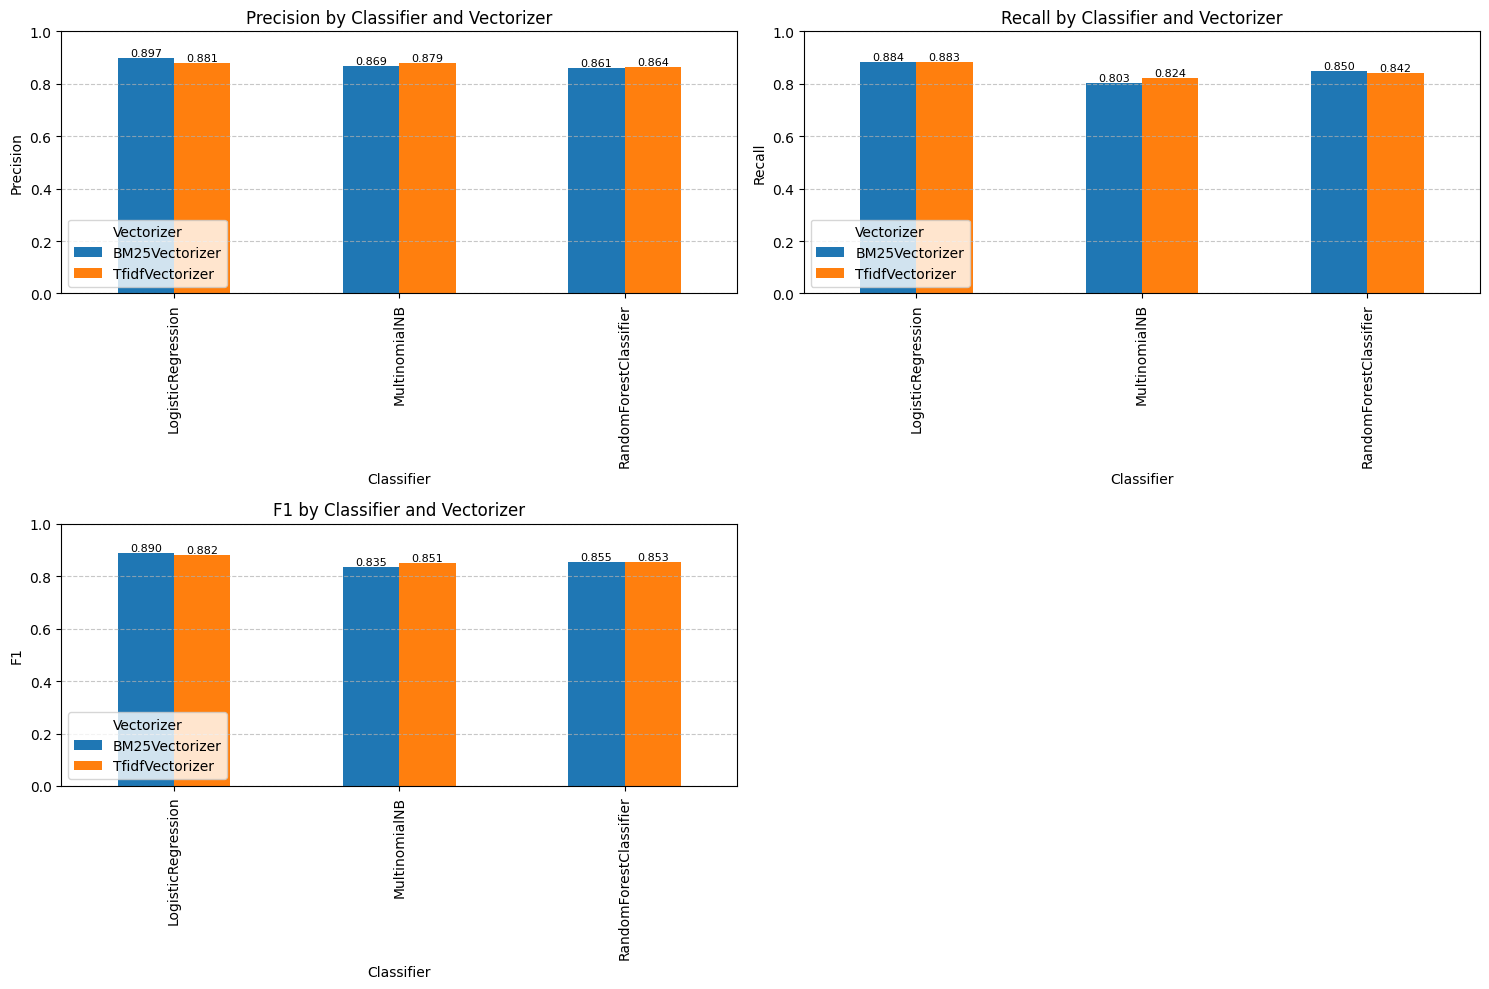

In [17]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(15, 10))
metrics = ['Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    # Group by vectorizer and classifier
    grouped = results_df.pivot(index='Classifier', columns='Vectorizer', values=metric)
    
    # Plot grouped bar chart
    ax = grouped.plot(kind='bar', ax=plt.gca())
    plt.title(f'{metric} by Classifier and Vectorizer')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.show()

That's interesting. we see that the reuslts are not that different (less than 2 points generally). And the logistic regression and random forest shows that the BM25 is slightly better than the TF-IDF. The multinomial naive bayes shows the opposite.

The results follows the observation we made on the retrieval services. 

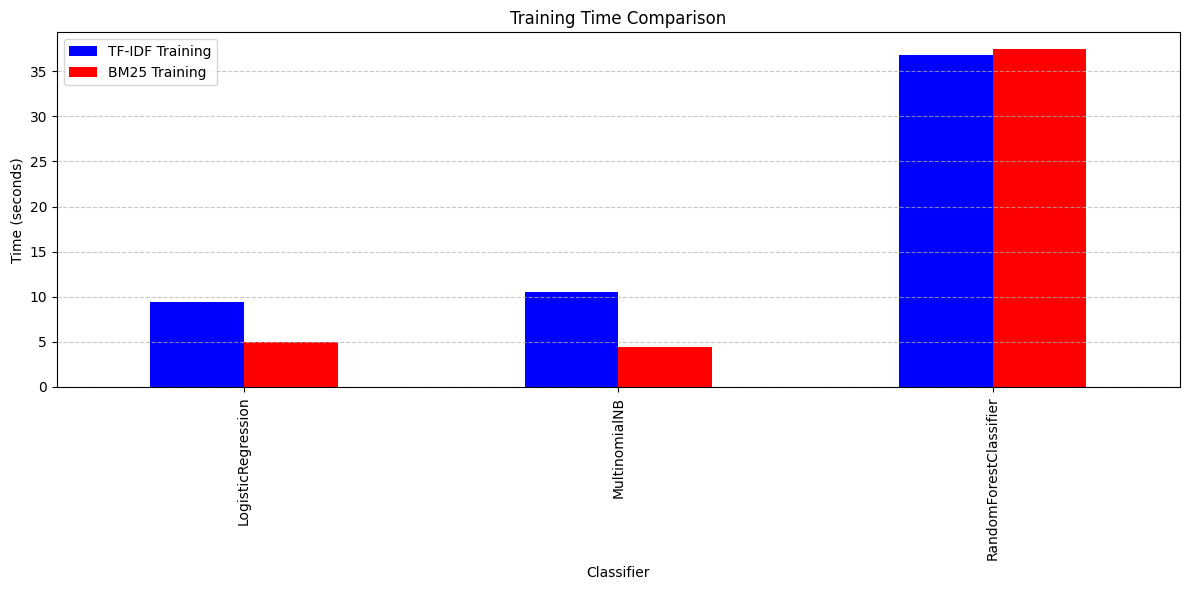

In [18]:
plt.figure(figsize=(12, 6))
    
# Create a time comparison plot
time_df = results_df.pivot(index='Classifier', columns='Vectorizer', values='Training Time')
ax = time_df.plot(kind='bar', color=['blue', 'red'], ax=plt.gca())

# Combine legends
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2] + handles[2:4], 
            ['TF-IDF Training', 'BM25 Training'],
            loc='upper left')

plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

On the training time it looks like the BM25 is slightly faster than the TF-IDF.

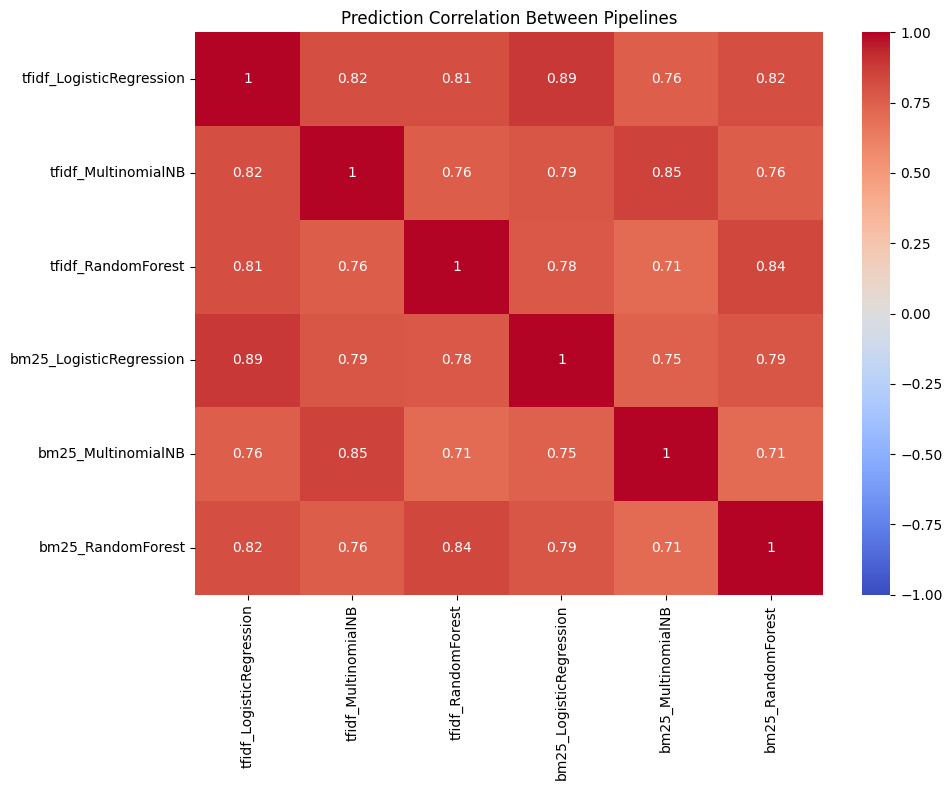

In [19]:
pred_df = pd.DataFrame({k: v for k, v in all_predictions.items()})

plt.figure(figsize=(10, 8))
corr_matrix = pred_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Prediction Correlation Between Pipelines')
plt.tight_layout()
plt.show()

We see again that we have high correlation between outputs when we look at the same model. Like 0.89 for logistic regression 0.85 for multinomial and 0.84 for Random Forest. 

There are differences obviously, let's look maybe at the differences in the interpretation of the results for logistic regression for instance.

In [20]:
from IPython.display import display, HTML

# Function to extract token weights from vectorizer
def get_token_weights(text, vectorizer):
    """Extract weights for each token in a text using the given vectorizer."""
    # Transform the text to a vector
    vector = vectorizer.transform([text])[0]
    
    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract non-zero weights and their corresponding tokens
    token_weights = {}
    
    # Split the text into tokens (considering the tokenization used by vectorizer)
    if hasattr(vectorizer, 'preprocessor') and vectorizer.preprocessor is not None:
        preprocessed_text = vectorizer.preprocessor(text)
    else:
        preprocessed_text = text
    
    if hasattr(vectorizer, 'tokenizer') and vectorizer.tokenizer is not None:
        tokens = vectorizer.tokenizer(preprocessed_text)
    else:
        # Default token pattern
        import re
        tokens = re.findall(vectorizer.token_pattern, preprocessed_text)
    
    # Handle ngrams by creating all possible ngrams from tokens
    ngrams = []
    for n in range(vectorizer.ngram_range[0], vectorizer.ngram_range[1] + 1):
        for i in range(len(tokens) - n + 1):
            ngrams.append(' '.join(tokens[i:i+n]))
    
    # Create a mapping from token indices to weights
    indices = vector.indices
    data = vector.data
    
    # Map feature indices to weights
    idx_to_weight = {idx: weight for idx, weight in zip(indices, data)}
    
    # Map tokens to weights
    for token in set(ngrams):
        if token.lower() in feature_names:
            idx = np.where(feature_names == token.lower())[0][0]
            if idx in idx_to_weight:
                token_weights[token] = idx_to_weight[idx]
    
    return token_weights

# Function to highlight text with both TF-IDF and BM25 weights
def highlight_text_comparison(text, tfidf_vectorizer, bm25_vectorizer, threshold=0.01, background=False):
    """
    Highlight tokens in text with different colors based on TF-IDF and BM25 weights.
    
    Parameters:
    -----------
    text : str
        Text to highlight
    tfidf_vectorizer : TfidfVectorizer
        Fitted TF-IDF vectorizer
    bm25_vectorizer : BM25Vectorizer
        Fitted BM25 vectorizer
    threshold : float, default=0.01
        Minimum weight to highlight
    background : bool, default=False
        Whether to highlight background instead of text
    
    Returns:
    --------
    str
        HTML-formatted text with highlights
    """
    # Get token weights
    tfidf_weights = get_token_weights(text, tfidf_vectorizer)
    bm25_weights = get_token_weights(text, bm25_vectorizer)
    
    # Normalize weights to [0, 1] range for better visualization
    max_tfidf = max(tfidf_weights.values()) if tfidf_weights else 1
    max_bm25 = max(bm25_weights.values()) if bm25_weights else 1
    
    # Split text into words and punctuation
    import re
    tokens = re.findall(r'\b\w[\w\']*\b|[^\w\s]', text)
    
    # Create highlighted HTML
    highlighted = []
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        
        # Get normalized weights
        tfidf_weight = tfidf_weights.get(token_lower, 0) / max_tfidf if max_tfidf > 0 else 0
        bm25_weight = bm25_weights.get(token_lower, 0) / max_bm25 if max_bm25 > 0 else 0
        
        # Determine if token should be highlighted
        if max(tfidf_weight, bm25_weight) > threshold:
            # Calculate RGB values for highlighting
            r = int(max(0, min(255, 255 * (1 - tfidf_weight))))
            g = int(max(0, min(255, 255 * (1 - bm25_weight))))
            b = 255  # Blue component remains constant
            
            if background:
                # Highlight background with opposite color
                bg_r = 255 - r
                bg_g = 255 - g
                bg_b = 255 - b
                token = f'<span style="background-color:rgb({bg_r},{bg_g},{bg_b})">{token}</span>'
            else:
                # Highlight text color
                token = f'<span style="color:rgb({r},{g},{b})">{token}</span>'
        
        highlighted.append(token)
    
    # Add a legend explaining the colors
    legend = """
    <div style="margin-top: 10px; font-size: 12px;">
        <b>Color Legend:</b><br>
        <span style="color:rgb(255,0,255)">Purple</span>: Low weight in both methods<br>
        <span style="color:rgb(0,0,255)">Blue</span>: High weight in both methods<br>
        <span style="color:rgb(255,0,0)">Red</span>: High TF-IDF weight, Low BM25 weight<br>
        <span style="color:rgb(0,255,0)">Green</span>: Low TF-IDF weight, High BM25 weight
    </div>
    """
    
    return ' '.join(highlighted) + legend


# Main function to display comprehensive comparison
def compare_vectorization_methods(reviews, tfidf_vectorizer=None, bm25_vectorizer=None):
    """
    Display comprehensive comparison of TF-IDF and BM25 vectorization for reviews.
    
    Parameters:
    -----------
    reviews : list of str
        List of reviews to analyze
    tfidf_vectorizer : TfidfVectorizer, optional
        Pre-fitted TF-IDF vectorizer
    bm25_vectorizer : BM25Vectorizer, optional
        Pre-fitted BM25 vectorizer
        
    Returns:
    --------
    None
        Displays HTML visualizations
    """
    
    # Display comparison for each review
    for i, review in enumerate(reviews):
        print(f"Review #{i+1}:")
        print("-" * 80)
        print(f"Text: {review[:150]}..." if len(review) > 150 else review)
        print()
        
        # Display combined highlighting
        display(HTML(f"<h3>Combined Highlighting (Review #{i+1})</h3>"))
        display(HTML(highlight_text_comparison(review, tfidf_vectorizer, bm25_vectorizer)))
        
        print("\n" + "=" * 80 + "\n")

# Example usage (replace this with your actual reviews dataset)
# Where both model differs

sample_reviews = test_df.loc[all_predictions['tfidf_LogisticRegression'] != all_predictions['bm25_LogisticRegression'], 'text'].sample(5, replace=False, random_state=42).tolist()

# Display the comparison
compare_vectorization_methods(sample_reviews, 
                              pipelines['tfidf_LogisticRegression']['vectorizer'],
                               pipelines['bm25_LogisticRegression']['vectorizer'])

Review #1:
--------------------------------------------------------------------------------
Text: The main word that comes to mind when considering this film is "dodgy". This is a low-quality film biography of one of the most iconic performers of a...





Review #2:
--------------------------------------------------------------------------------
Text: "Western Union" is something of a forgotten classic western! Perhaps the reason for this lies in the fact of its unavailability on DVD in the United S...





Review #3:
--------------------------------------------------------------------------------
Text: The sequel is exactly what you will expect it to be. And it is good enough that everyone who would have wanted to watch this should leave it happy.<br...





Review #4:
--------------------------------------------------------------------------------
Text: ''Wallace & Gromit in The Curse of the Were-Rabbit'' is the same type of animation and from the same creators of ''Chicken run'', but the story now is...





Review #5:
--------------------------------------------------------------------------------
Text: Hahahahah Probably one of the funniest movies i've even seen. Obviously this isn't intentional though. It takes about half the movie for the main char...



INteresting, on the first review the tf-idf focuses on "film" whereas it's not the case for the BM25. This is interesting and shows the capacities of the BM25 to reduce the weight of the terms that may be overweighted in the TF-IDF.